In [1]:
from fastai.vision.all import *
import tqdm

In [2]:
from sklearn.metrics import r2_score

In [3]:
PATH = Path('../input/optiver-realized-volatility-prediction')

data_df = pd.read_parquet(PATH/'book_train_reindexed.parquet')

sizes = ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']
for sz in sizes:
    data_df[sz] = data_df[sz]/ 1_000_000

train_df = pd.read_csv(PATH/'train_with_offset.csv')

In [4]:
#train_df['is_valid'] = train_df.time_id > 26000

In [5]:
# res =[]
# for idx in range(0,len(data_df), 600):
#     res.append((data_df.stock_id[idx], data_df.time_id[idx]))

# train_df['offset']=np.zeros(len(train_df))

# for idx, (stock_id, time_id) in tqdm.tqdm(enumerate(res)):
#         train_df.loc[(train_df.stock_id ==stock_id)&(train_df.time_id==time_id), 'offset']=600*idx

In [6]:
# for row in tqdm.tqdm(train_df.itertuples()):
#         idx = row.offset
#         assert data_df.stock_id[idx] == row.stock_id
#         assert data_df.time_id[idx] == row.time_id
#         assert data_df.seconds_in_bucket[idx] == 0

In [7]:
#train_df.to_csv(PATH/'train_with_offset.csv')

In [8]:
class LoadTransform(Transform):
    def __init__(self, data_df):
        super().__init__()
        self.data = data_df
        
    def encodes(self, row):
        df = self.data.iloc[row.offset:row.offset+600]
        ret = df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()
        ret = ret.reshape(1,600,8).astype('float32')
        return ret

tfm = LoadTransform(data_df)

data_block = DataBlock(
        blocks = (TransformBlock(type_tfms=tfm), 
                  RegressionBlock()),
        splitter=ColSplitter(),
        get_y=ColReader('target'),
)
dls = data_block.dataloaders(train_df, bs=128)

In [9]:
bx,by = dls.valid.one_batch()
bx.shape, by.shape

(torch.Size([128, 1, 600, 8]), torch.Size([128]))

In [10]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [11]:
def mspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean()

In [12]:
def rmspe_loss(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [13]:
learn = cnn_learner(dls, resnet18, n_in=1,loss_func=mspe_loss, metrics=AccumMetric(rmspe), y_range=(0,0.1))

SuggestedLRs(lr_min=0.33113112449646, lr_steep=9.12010818865383e-07)

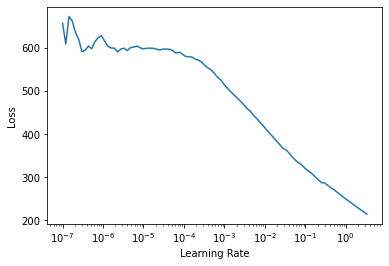

In [14]:
learn.lr_find()

In [15]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,rmspe,time
0,0.579954,6.510806,3.816154,01:14
1,0.376856,0.333770,0.576098,01:14


KeyboardInterrupt: 

In [ ]:
train_df.target.max()

In [ ]:
preds, tars = learn.get_preds()

In [ ]:
preds[:5], tars[:5]

In [ ]:
rmspe(preds.view(-1), tars)

In [ ]:
def rmspe_np(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
rmspe_np( tars.numpy(),preds.view(-1).numpy())